# Distinguish Your Own Digits (DYOD)

You are going to write a classifier that distinguishes between the number 3 and number 8.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

From the command line run `pip install mnist`. This is a library that will help you bring down the mnist dataset. If you run this from a notebook, you need to put  `!pip install mnist` in a cell by itself.

In [3]:
!pip install mnist

## Preparing the Data

In [4]:
import mnist

In [5]:
train_images = mnist.train_images()
train_labels = mnist.train_labels()

In [6]:
train_images.shape, train_labels.shape

((60000, 28, 28), (60000,))

In [7]:
test_images = mnist.test_images()
test_labels = mnist.test_labels()

In [8]:
test_images.shape, test_labels.shape

((10000, 28, 28), (10000,))

2


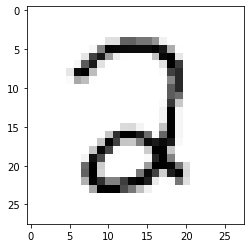

In [9]:
image_index = 7776 # You may select anything up to 60,000
print(train_labels[image_index]) 
plt.imshow(train_images[image_index], cmap='Greys')

## Filter data to get 3 and 8 out

In [10]:
train_filter = np.where((train_labels == 3 ) | (train_labels == 8))
test_filter = np.where((test_labels == 3) | (test_labels == 8))
X_train, y_train = train_images[train_filter], train_labels[train_filter]
X_test, y_test = test_images[test_filter], test_labels[test_filter]

We normalize the pizel values in the 0 to 1 range

In [11]:
X_train = X_train/255.
X_test = X_test/255.

And setup the labels as 1 (when the digit is 3) and 0 (when the digit is 8)

In [12]:
y_train = 1*(y_train==3)
y_test = 1*(y_test==3)

In [13]:
X_train.shape, X_test.shape

((11982, 28, 28), (1984, 28, 28))

We reshape the data to flatten the image pixels into a set of features or co-variates:

In [14]:
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)
X_train.shape, X_test.shape

((11982, 784), (1984, 784))

In [15]:
#Impoting functions from 'Kudzu'
from kudzu.model import Model
from kudzu.train import Learner
from kudzu.optim import GD
from kudzu.data import Data, Sampler,Dataloader

from kudzu.callbacks import AccCallback
from kudzu.callbacks import ClfCallback

from kudzu.loss import MSE

from kudzu.layer import Sigmoid,Relu
from kudzu.layer import Affine

### Let us create a `Config` class, to store important parameters. 
This class essentially plays the role of a dictionary.

In [16]:
class Config:
    pass
config = Config()
config.lr = 0.001
config.num_epochs = 250
config.bs = 50

### Running Models with the Training data
Details about the network layers:
- A first affine layer has 784 inputs and does 100 affine transforms. These are followed by a Relu
- A second affine layer has 100 inputs from the 100 activations of the past layer, and does 100 affine transforms. These are followed by a Relu
- A third affine layer has 100 activations and does 2 affine transformations to create an embedding for visualization. There is no non-linearity here.
- A final "logistic regression" which has an affine transform from 2 inputs to 1 output, which is squeezed through a sigmoid.


In [17]:
data = Data(X_train, y_train.reshape(-1,1))
sampler = Sampler(data, config.bs, shuffle=True)

dl = Dataloader(data, sampler)

opt = GD(config.lr)
loss = MSE()

In [18]:
training_data_x = X_train
testing_data_x = X_test
training_data_y = y_train.reshape(-1,1)
testing_data_y = y_test.reshape(-1,1)

In [19]:
layers = [Affine("first", 784, 100), Relu("first"), Affine("second", 100, 100), Relu("second"), Affine("third", 100, 2), Affine("last", 2, 1), Sigmoid("last")]
model_nn = Model(layers)
model_lr = Model([Affine("logits", 784, 1), Sigmoid("sigmoid")])

xavier
xavier
xavier
xavier
xavier


In [20]:
nn_learner = Learner(loss, model_nn, opt, config.num_epochs)
acc_nn = ClfCallback(nn_learner, config.bs, training_data_x , testing_data_x, training_data_y, testing_data_y)
nn_learner.set_callbacks([acc_nn])

In [21]:
lr_learner = Learner(loss, model_lr, opt, config.num_epochs)
acc_lr = ClfCallback(lr_learner, config.bs, training_data_x , testing_data_x, training_data_y, testing_data_y)
lr_learner.set_callbacks([acc_lr])

In [22]:
nn_learner.train_loop(dl)

Epoch 0, Loss 0.2524
Training Accuracy: 0.5404, Testing Accuracy: 0.5307



Epoch 10, Loss 0.1261
Training Accuracy: 0.8998, Testing Accuracy: 0.9098



Epoch 20, Loss 0.0669
Training Accuracy: 0.9347, Testing Accuracy: 0.9456



Epoch 30, Loss 0.0494
Training Accuracy: 0.9467, Testing Accuracy: 0.9546



Epoch 40, Loss 0.0417
Training Accuracy: 0.9527, Testing Accuracy: 0.9617



Epoch 50, Loss 0.0374
Training Accuracy: 0.9574, Testing Accuracy: 0.9667



Epoch 60, Loss 0.0345
Training Accuracy: 0.9592, Testing Accuracy: 0.9672



Epoch 70, Loss 0.0324
Training Accuracy: 0.9613, Testing Accuracy: 0.9698



Epoch 80, Loss 0.0307
Training Accuracy: 0.9631, Testing Accuracy: 0.9693



Epoch 90, Loss 0.0294
Training Accuracy: 0.9640, Testing Accuracy: 0.9698



Epoch 100, Loss 0.0283
Training Accuracy: 0.9658, Testing Accuracy: 0.9698



Epoch 110, Loss 0.0273
Training Accuracy: 0.9677, Testing Accuracy: 0.9688



Epoch 120, Loss 0.0265
Training Accuracy: 0.9692, Testing Accuracy: 0.9688



Epoch 130, Loss 0.0257
Training Accuracy: 0.9700, Testing Accuracy: 0.9682



Epoch 140, Loss 0.025
Training Accuracy: 0.9712, Testing Accuracy: 0.9688



Epoch 150, Loss 0.0244
Training Accuracy: 0.9719, Testing Accuracy: 0.9693



Epoch 160, Loss 0.0238
Training Accuracy: 0.9732, Testing Accuracy: 0.9703



Epoch 170, Loss 0.0232
Training Accuracy: 0.9737, Testing Accuracy: 0.9703



Epoch 180, Loss 0.0227
Training Accuracy: 0.9741, Testing Accuracy: 0.9698



Epoch 190, Loss 0.0222
Training Accuracy: 0.9746, Testing Accuracy: 0.9703



Epoch 200, Loss 0.0217
Training Accuracy: 0.9751, Testing Accuracy: 0.9703



Epoch 210, Loss 0.0213
Training Accuracy: 0.9756, Testing Accuracy: 0.9713



Epoch 220, Loss 0.0208
Training Accuracy: 0.9764, Testing Accuracy: 0.9718



Epoch 230, Loss 0.0204
Training Accuracy: 0.9771, Testing Accuracy: 0.9733



Epoch 240, Loss 0.02
Training Accuracy: 0.9773, Testing Accuracy: 0.9733



0.022453041482110168

In [23]:
lr_learner.train_loop(dl)

Epoch 0, Loss 0.2454
Training Accuracy: 0.6833, Testing Accuracy: 0.6683



Epoch 10, Loss 0.104
Training Accuracy: 0.9111, Testing Accuracy: 0.9204



Epoch 20, Loss 0.0795
Training Accuracy: 0.9289, Testing Accuracy: 0.9390



Epoch 30, Loss 0.0683
Training Accuracy: 0.9380, Testing Accuracy: 0.9461



Epoch 40, Loss 0.0616
Training Accuracy: 0.9422, Testing Accuracy: 0.9531



Epoch 50, Loss 0.057
Training Accuracy: 0.9458, Testing Accuracy: 0.9551



Epoch 60, Loss 0.0537
Training Accuracy: 0.9485, Testing Accuracy: 0.9561



Epoch 70, Loss 0.0511
Training Accuracy: 0.9499, Testing Accuracy: 0.9582



Epoch 80, Loss 0.0491
Training Accuracy: 0.9508, Testing Accuracy: 0.9597



Epoch 90, Loss 0.0474
Training Accuracy: 0.9523, Testing Accuracy: 0.9592



Epoch 100, Loss 0.046
Training Accuracy: 0.9536, Testing Accuracy: 0.9622



Epoch 110, Loss 0.0448
Training Accuracy: 0.9544, Testing Accuracy: 0.9632



Epoch 120, Loss 0.0437
Training Accuracy: 0.9548, Testing Accuracy: 0.9637



Epoch 130, Loss 0.0428
Training Accuracy: 0.9554, Testing Accuracy: 0.9627



Epoch 140, Loss 0.042
Training Accuracy: 0.9563, Testing Accuracy: 0.9637



Epoch 150, Loss 0.0412
Training Accuracy: 0.9568, Testing Accuracy: 0.9647



Epoch 160, Loss 0.0406
Training Accuracy: 0.9570, Testing Accuracy: 0.9647



Epoch 170, Loss 0.04
Training Accuracy: 0.9576, Testing Accuracy: 0.9652



Epoch 180, Loss 0.0394
Training Accuracy: 0.9585, Testing Accuracy: 0.9652



Epoch 190, Loss 0.0389
Training Accuracy: 0.9589, Testing Accuracy: 0.9652



Epoch 200, Loss 0.0384
Training Accuracy: 0.9593, Testing Accuracy: 0.9652



Epoch 210, Loss 0.038
Training Accuracy: 0.9601, Testing Accuracy: 0.9652



Epoch 220, Loss 0.0376
Training Accuracy: 0.9599, Testing Accuracy: 0.9652



Epoch 230, Loss 0.0372
Training Accuracy: 0.9601, Testing Accuracy: 0.9642



Epoch 240, Loss 0.0368
Training Accuracy: 0.9602, Testing Accuracy: 0.9647



0.04632907878097182

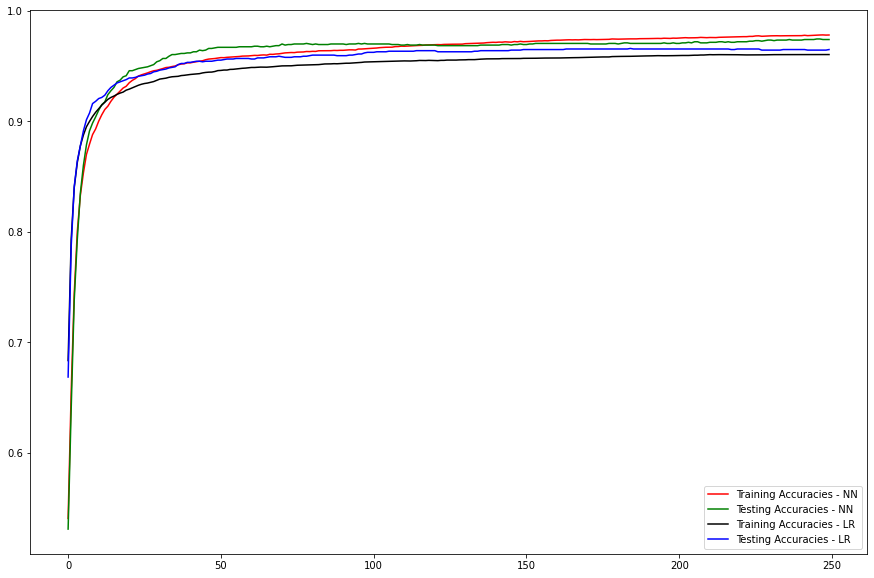

In [24]:
#comparing the results of NN and LR
plt.figure(figsize=(15,10))

# Neural Network plots
plt.plot(acc_nn.accuracies, 'r-', label = "Training Accuracies - NN")
plt.plot(acc_nn.test_accuracies, 'g-', label = "Testing Accuracies - NN")

# Logistic Regression plots
plt.plot(acc_lr.accuracies, 'k-', label = "Training Accuracies - LR")
plt.plot(acc_lr.test_accuracies, 'b-', label = "Testing Accuracies - LR")
plt.legend()

#### Plotting the outputs of this layer of the NN.


In [25]:
new_model = Model(layers[:-2])
testing_plot = new_model(testing_data_x)

Text(0.5, 1.0, 'Outputs')

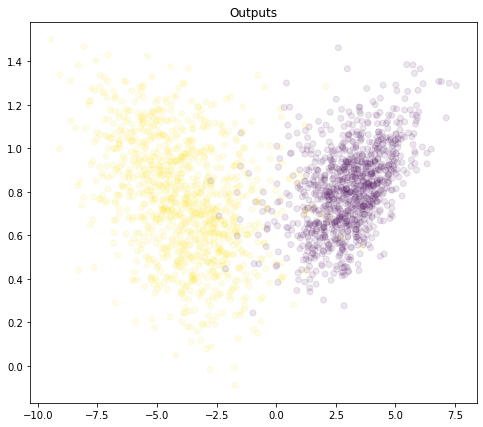

In [26]:
# Plotting the scatter plot of points and color coding by class
plt.figure(figsize=(8,7))
plt.scatter(testing_plot[:,0], testing_plot[:,1], alpha = 0.1, c = y_test.ravel());
plt.title('Outputs')

Probability contours

In [27]:
model_prob = Model(layers[-2:]) 

In [28]:
#creating the x and y ranges according to the above generated plot.
x_range = np.linspace(-4, 1, 100) 
y_range = np.linspace(-6, 6, 100) 
x_grid, y_grid = np.meshgrid(x_range, y_range) # x_grid and y_grig are of size 100 X 100

# converting x_grid and y_grid to continuous arrays
x_gridflat = np.ravel(x_grid)
y_gridflat = np.ravel(y_grid)

# The last layer of the current model takes two columns as input. Hence transpose of np.vstack() is required.
X = np.vstack((x_gridflat, y_gridflat)).T

prob_contour = model_prob(X).reshape(100,100) 

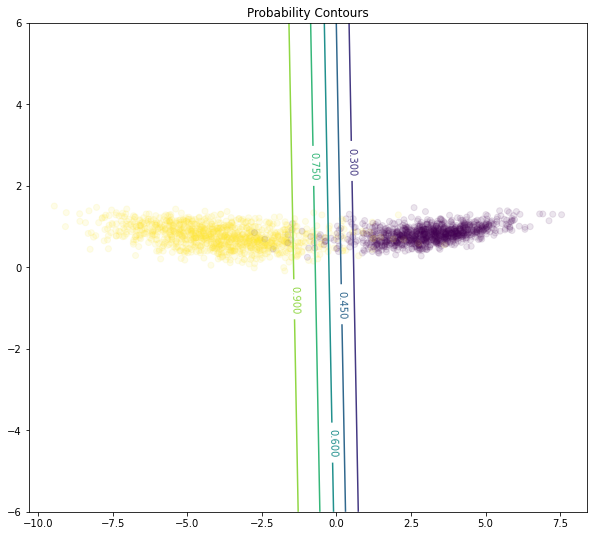

In [29]:
plt.figure(figsize=(10,9))
plt.scatter(testing_plot[:,0], testing_plot[:,1], alpha = 0.1, c = y_test.ravel())
contours = plt.contour(x_grid,y_grid,prob_contour)
plt.title('Probability Contours')
plt.clabel(contours, inline = True );